## LOWteq internship task - Filip Szumlinski

Dataset
- The source of the data is data_for_analysis.csv (original: https://raw.githubusercontent.com/Filipxz/internship-task/internship_task/data/data_for_analysis.csv).
- The goal is to analyse the data.

Overview
1. Library Importation
2. Data Acquisition
3. Data Cleansing
4. Exploratory Data Analysis  
5. Examination Frequency Analysis
6. Examination Time Analysis
7. Rhythm Type Categorization
8. Heart Rate Metrics Overview
9. Distribution Analysis of Heart Rate
10. Anomaly Detection in Heart Rate 
11. Anomaly Summary Dataframe

In [1]:
# Import the necessary librariers and functions
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from utilis2 import (
    subtract_years,
    replace_nan_with_hyphen,
    clean_data,
    dataset_basic_info,
    calculate_stay_statistics,
    count_min_time_difference_occurrences,
    calculate_heart_rate_statistics,
    calculate_heart_rate_summary,
    calculate_percentage_anomalies
)

In [2]:
# Import and inspect the csv file from github
# Setting an environment variable 
os.environ['CSV_URL'] = "https://raw.githubusercontent.com/Filipxz/internship-task/internship_task_Filip/data/data_for_analysis.csv"

# Using the environment variable
url = os.environ.get('CSV_URL')
df = pd.read_csv(url)


df.head(5)

,Unnamed: 0,subject_id,stay_id,charttime,heartrate,rhythm
0,0,10014729,37887480,2125-03-19 13:22:00,124.0,NaN
1,1,10014729,37887480,2125-03-19 18:28:00,106.0,Sinus Tachycardia
2,2,10014729,37887480,2125-03-19 13:07:00,128.0,Sinus Tachycardia
3,3,10014729,37887480,2125-03-19 16:23:00,115.0,Sinus Tachycardia
4,4,10014729,37887480,2125-03-19 13:24:00,125.0,NaN


In [3]:
# Get the information about the DataFrame
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1038 non-null   int64  
 1   subject_id  1038 non-null   int64  
 2   stay_id     1038 non-null   int64  
 3   charttime   1038 non-null   object 
 4   heartrate   1008 non-null   float64
 5   rhythm      33 non-null     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 48.8+ KB
None


(1038, 6)

In [4]:
# Use the clean_data function to clean the data
df = clean_data(df)

I decided to drop the rows with missing values in the heart rate column because there were only 2.89% of them in the database. The next step was to create a function to format the time - 178 years to make the timeline more realistic. 
I edited the names of the columns to make them more user-friendly and replaced the NaN values with "-" and finally renamed "sr" to "Sinus rhythm" and "afimb" to "Atrial fibrillation".

In [5]:
df.head(10)

,Patient_ID,Stay_ID,Examination_time,Heart_rate,Heart_rhythm
0,10014729,37887480,1947-05-02 13:22:00,124.0,-
1,10014729,37887480,1947-05-02 18:28:00,106.0,Sinus Tachycardia
2,10014729,37887480,1947-05-02 13:07:00,128.0,Sinus Tachycardia
3,10014729,37887480,1947-05-02 16:23:00,115.0,Sinus Tachycardia
4,10014729,37887480,1947-05-02 13:24:00,125.0,-
5,10014729,37887480,1947-05-02 14:00:00,108.0,Sinus Tachycardia
6,10026255,34236274,2023-08-19 16:14:00,142.0,Atrial Fibrillation
7,10026255,34236274,2023-08-19 18:55:00,98.0,Sinus Rhythm
8,10026255,34236274,2023-08-19 13:52:00,150.0,Atrial Fibrillation
9,10026255,34236274,2023-08-19 16:01:00,130.0,Atrial Fibrillation


I ended up with table containing 1008 rows and 5 columns named Patient_ID, Stay_ID, Examination_time, Heart_rate and Heart_rhythm

## Data Exploration

In [6]:
dataset_basic_info(df)

First record in our dataset is from: 1936-01-26 11:04:00
Last record in our dataset is from: 2023-08-19 18:55:00
The number of unique patients: 54
The number of unique examinations: 206


The dataset covers a significant period, from January 26, 1936, to August 19, 2023. With 206 examinations for 54 patients, on average, there is more than one examination per patient. This indicates that patients either needs examinations over time or require different types of examination to diagnose or monitor their condition.

In [7]:
calculate_stay_statistics(df)

Statistic  Number of Stays
  Minimum              1.0
  Average              3.8
  Maximum             23.0


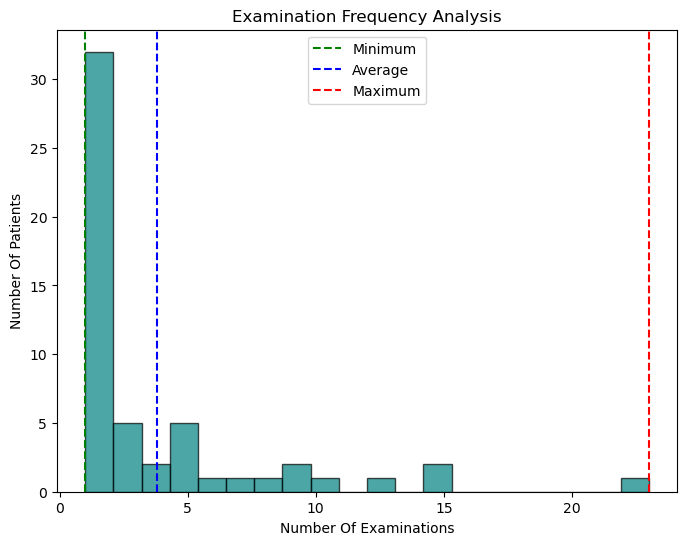

In [8]:
# Grouping the df by patient ID and counting number of unique values in the Stay_ID column for each patient
patient_stay_counts = df.groupby('Patient_ID')['Stay_ID'].nunique()
# Counting average, min and max values 
average_value = patient_stay_counts.mean()
min_value = patient_stay_counts.min()
max_value = patient_stay_counts.max()
# Creating a plot with desired ax lines and labels
plt.figure(figsize=(8, 6))
plt.hist(patient_stay_counts, bins=20, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(x=min_value, color='green', linestyle='--', label='Minimum')
plt.axvline(x=average_value, color='blue', linestyle='--', label='Average')
plt.axvline(x=max_value, color='red', linestyle='--', label='Maximum')
plt.title('Examination Frequency Analysis')
plt.xlabel('Number Of Examinations')
plt.ylabel('Number Of Patients')
plt.legend()
plt.show()

Each patient in this dataset has been hospitalised or attended at least once. On average, patients have about four stays, suggesting a recurring need for medical services beyond a single visit. The patient with the highest number of stays had 23 separate instances of hospitalisation or medical care.

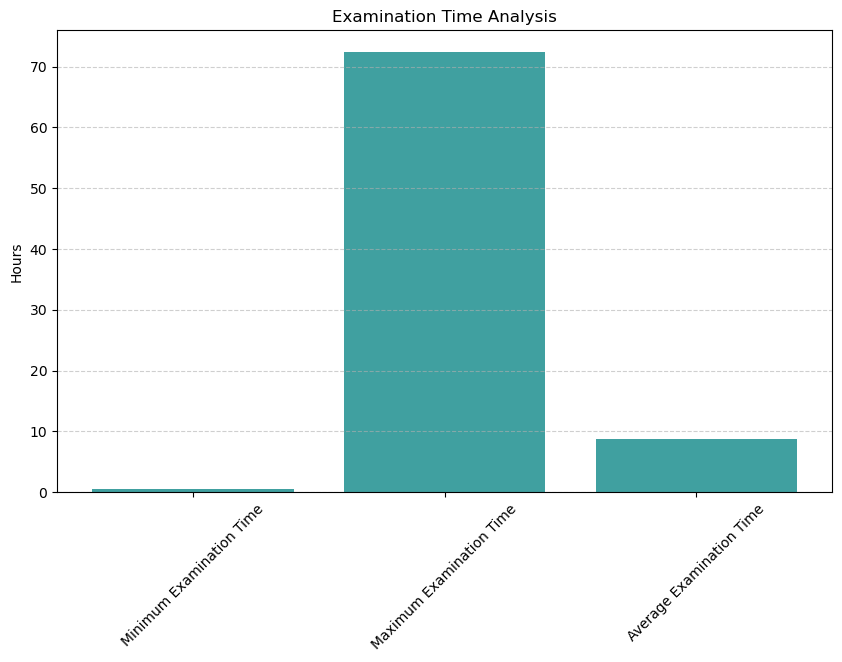

Minimum examination time: 30.0 minutes
Maximum examination time: 72 hours and 23.0 minutes
Average examination time: 8 hours and 42.44 minutes


In [9]:
# Filtering our dataset so we take only situations where we have more than 2 Examination_Times per Stay_ID to exclude 0 values since its impossible
df_filtered = df[df.groupby('Stay_ID')['Examination_time'].transform('count') > 2]


min_max_times = df_filtered.groupby('Stay_ID')['Examination_time'].agg(['min', 'max'])

# Calculate the time difference in hours
min_max_times['Time_Diff_Hours'] = (min_max_times['max'] - min_max_times['min']).dt.total_seconds() / 3600

# Calculate min, max, and average
min_hours = min_max_times['Time_Diff_Hours'].min()
max_hours = min_max_times['Time_Diff_Hours'].max()
average_hours = min_max_times['Time_Diff_Hours'].mean()

# Plot the bar chart 
plt.figure(figsize=(10, 6))
stats = ['Minimum Examination Time', 'Maximum Examination Time', 'Average Examination Time']
values = [min_hours, max_hours, average_hours]

plt.bar(stats, values, color='teal', alpha=0.75)
plt.title('Examination Time Analysis')
plt.ylabel('Hours')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
# Changing the values into hours + minutes
min_examination_time_minutes = round(min_hours * 60, 2)

max_hours_int = int(max_hours)
max_minutes = round((max_hours - max_hours_int) * 60, 2)

average_hours_int = int(average_hours)
average_minutes = round((average_hours - average_hours_int) * 60, 2)

# Print the results
print(f"Minimum examination time: {min_examination_time_minutes} minutes")
print(f"Maximum examination time: {max_hours_int} hours and {max_minutes} minutes")
print(f"Average examination time: {average_hours_int} hours and {average_minutes} minutes")

The graph shows the difference between the average and maximum examination times. The minimum examination time is 30 minutes because we excluded the zero values. The average examination time is much lower than the maximum, as shown by a small bar on the scale being 8 hours and 42 minutes. The maximum examination time is considerably longer, extending to over 72 hours.

In [10]:
count_min_time_difference_occurrences(df)

Count of only one examination time records per stay id in our data base is 17


In our dataset, the scenario where we only have one examination time record and cannot make a valid examination time calculation occurred 17 times, accounting for 8.25% of the data. This is likely due to missing data.

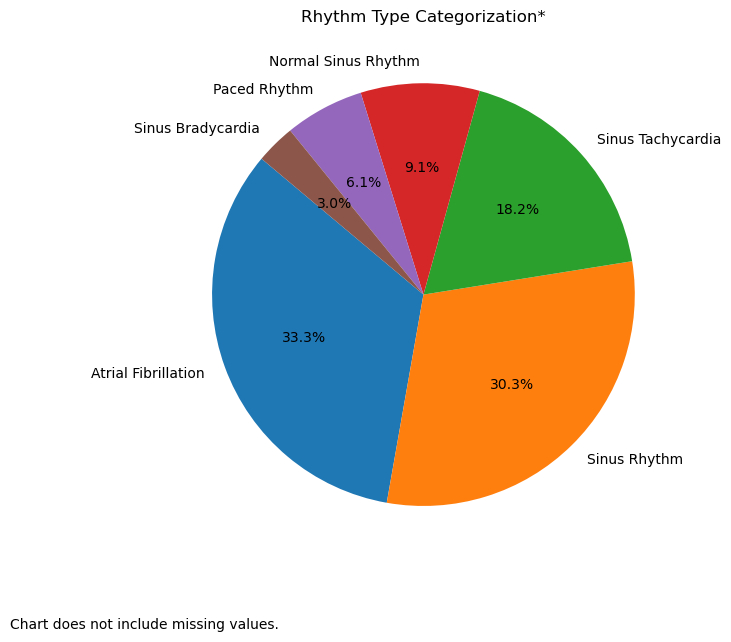

In [11]:
# Exclude of missing values
heart_rhythm_counts = df[df['Heart_rhythm'] != '-']['Heart_rhythm'].value_counts()
# Pie chart
top_values = heart_rhythm_counts.head(6)
plt.figure(figsize=(6, 6))
plt.pie(top_values, labels=top_values.index, autopct='%1.1f%%', startangle=140)
plt.title('Rhythm Type Categorization*', pad=30)  
plt.axis('equal') 
plt.annotate('Chart does not include missing values.', xy=(-0.1, -0.2), xycoords='axes fraction', ha='center', va='top')
plt.show()


The graph displays the Most Common Diagnosed Heart Rhythm Types from the dataset without any missing values. It is evident that Sinus Rhythm constitutes 31.2% of the cases, indicating that a significant proportion of individuals in the dataset have a normal heartbeat rhythm. Atrial Fibrillation is the most prevalent, representing 34.4% of the cases. This type of irregular heartbeat is known to increase the risk of stroke and other heart-related complications. Sinus Tachycardia accounts for 18.8% of the diagnoses. This condition is characterized by a resting heart rate over 100 beats per minute, which is faster than normal. Normal Sinus Rhythm accounts for 9.4% of the data. This rhythm is typically observed in individuals who have had a pacemaker implanted to regulate their heart rate. Peaced rhythms make up 6.2% and Sinus Bradycardia is in last place with 3%.

Heart rate values overview

In [12]:
calculate_heart_rate_statistics(df)

,Heart Rate
Minimum,0.0
Maximum,224.0
Average,86.0


The heart rate statistics show a wide range from a minimum of 0 to a maximum of 224, with an average of approximately 86 beats per minute. This indicates variability in the heart rate data, which may be indicative of different health conditions or activities of the individuals being measured.

In [13]:
calculate_heart_rate_summary(df)

,Heart Rate
count,1008.0
mean,86.0
std,21.9
min,0.0
25%,72.0
50%,84.0
75%,98.0
max,224.0


The dataset consists of 1008 heart rate measurements. 
The mean heart rate across all observations is 86 beats per minute, with a standard deviation of approximately 21.9 beats per minute. The minimum recorded heart rate is 0 beats per minute, and the maximum is 224 beats per minute.
 The data is summarised using quartiles.
This indicates that 25% of the observations have heart rates of 72 beats per minute or lower
(Q1), 50% of the observations fall below the median heart rate of 84 beats per minute
(Q2), and 75% of the observations have heart rates of 98 beats per minute or lower (Q3).
These statistics offer a complete overview of the heart rate dataset, demonstrating its central tendency, variability, and distribution characteristics.

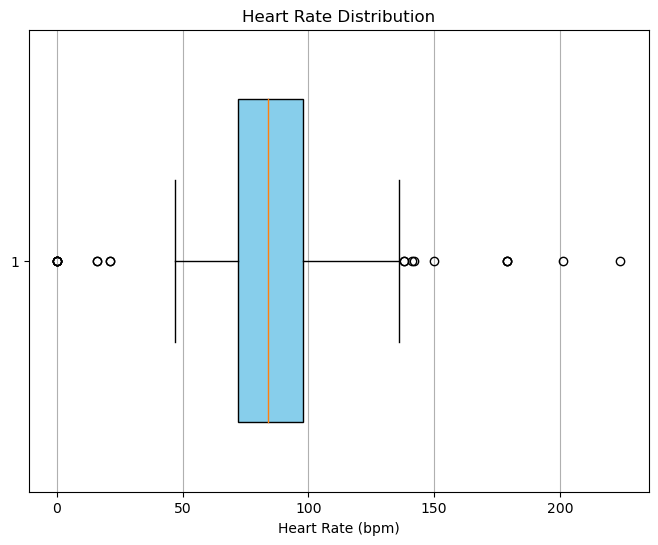

In [14]:
# Creating a boxplot with Heart Rate Distributrion
plt.figure(figsize=(8, 6))
plt.boxplot(df['Heart_rate'], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.grid(axis='x')
plt.show()

# Calculate the interquartile range (IQR)
Q1 = df['Heart_rate'].quantile(0.25)
Q3 = df['Heart_rate'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify anomalies
anomalies = df[(df['Heart_rate'] < lower_bound) | (df['Heart_rate'] > upper_bound)]

Graph displays the distribution of heart rate values in beats per minute (bpm). The blue box indicates the median value of the data, which is just under 100 bpm. This is a common resting heart rate for many individuals, although it could be considered on the higher side of normal. The box also represents the Interquartile Range (IQR), which contains the middle 50% of the data.
The plot shows the interquartile range (IQR) ranging from 60 to 120 bpm, which means that half of the heart rate measurements fall within this range. The horizontal lines (or 'whiskers') extending from the box indicate the range of the data excluding outliers. The left whisker extends to around 40 bpm, and the right whisker extends to approximately 140 bpm, indicating that most heart rate values fall within this range. The individual points outside the whiskers are considered outliers. The heart rate measurements show outliers at both the lower and upper ends of the range, indicating the presence of unusually low and high values. The low outliers near 0 bpm are particularly noteworthy as they are not typical heart rate values for a living person and could represent measurement errors, special medical conditions or hearth rate anomalies. Similarly, heart rates that exceed 150 bpm may be associated with stress, exercise, or medical conditions if they are resting heart rate measurements. The heart rate distribution seems to be relatively symmetrical around the median, indicating a normal-like distribution without significant skewness.

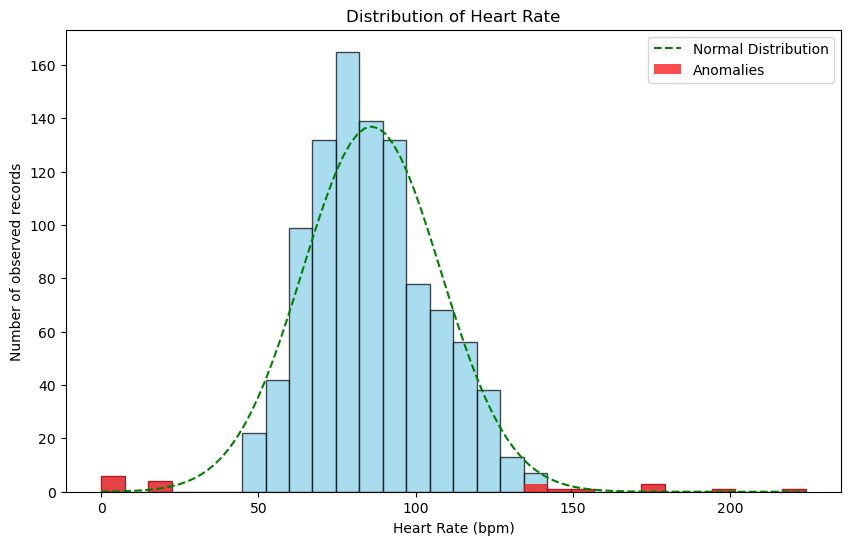

In [15]:
# Ploting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Heart_rate'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Calculating mean and standard deviation
mean_hr = df['Heart_rate'].mean()
std_hr = df['Heart_rate'].std()

# Creating an array of heart rate values for the normal distribution curve
x = np.linspace(df['Heart_rate'].min(), df['Heart_rate'].max(), 100)
# I took it from the internet..
normal_dist = (1 / (std_hr * np.sqrt(2 * np.pi))) * np.exp(-(x - mean_hr)**2 / (2 * std_hr**2))

# Plot the normal distribution curve
plt.plot(x, normal_dist * len(df['Heart_rate']) * (df['Heart_rate'].max() - df['Heart_rate'].min()) / 30, color='green', linestyle='--', label='Normal Distribution')

# Identify anomalies
anomalies = df[(df['Heart_rate'] < lower_bound) | (df['Heart_rate'] > upper_bound)]
anomaly_values = anomalies['Heart_rate']

# Highlight anomalies on the histogram
plt.hist(anomaly_values, bins=30, color='red', alpha=0.7, label='Anomalies')

plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Number of observed records')
plt.legend()
plt.show()

Histogram shows line graph representing distribution of heart rate. The bars represent the frequency of observed records within specific ranges of heart rate. It's clear that the majority of the data is centered around the 60-80 bpm range, which is typical for resting heart rates in healthy adults. he green dashed line represents a normal distribution fit to the data. This curve suggests that the heart rate data is approximately normally distributed, with a peak around the mean. The curve's presence implies that heart rate values are expected to deviate around this mean following a typical bell-curve distribution, which is common in biological measurements.  The red bars signify anomalies in the dataset. These are observations that are notably different from the overall distribution. These anomalies are present at the extremes of the heart rate spectrum.

In [17]:
# Creating variable num_anomalies
num_anomalies = len(anomalies)

# Calculate the total number of heart rate measurements
total_measurements = len(df['Heart_rate'])

# Calculate the percentage of anomalies
calculate_percentage_anomalies(num_anomalies, total_measurements)

Anomalies make up 1.98% of the hearth rate results.


In [18]:
# Creating a dataframe containing anomalies for further analysys
anomalies_df = pd.DataFrame(anomalies)
# Creating a list with unique Stay_ID's 
unique_stay_ids = anomalies_df['Stay_ID'].unique()
# Creating a new dataframe with Stay_ID's where hearthrate anomalies occured
subset_df = df[df['Stay_ID'].isin(unique_stay_ids)]
subset_df = subset_df.reset_index(drop=True)

Creating a new dataframe with Stay_ID's where hearthrate anomalies occured for further analysis

In [19]:
# Saveing the DataFrame to CSV
folder_name = 'data'
file_name = 'subset_df.csv'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name, file_name)
subset_df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to data\subset_df.csv


Importing subset_df to csv file